# Information

* site_id - ID code for the source hospital.
  
* patient_id - ID code for the patient.
* image_id - ID code for the image.
* laterality - Whether the image is of the left or right breast.
* view - The orientation of the image. The default for a screening exam is to capture two views per breast.
* age - The patient's age in years.
* implant - Whether or not the patient had breast implants. Site 1 only provides breast implant information at the patient level, not at the breast level.
* density - A rating for how dense the breast tissue is, with A being the least dense and D being the most dense. Extremely dense tissue can make diagnosis more difficult. Only provided for train.
* machine_id - An ID code for the imaging device.
* cancer - Whether or not the breast was positive for malignant cancer. The target value. Only provided for train.
* biopsy - Whether or not a follow-up biopsy was performed on the breast. Only provided for train.
* invasive - If the breast is positive for cancer, whether or not the cancer proved to be invasive. Only provided for train.
* BIRADS - 0 if the breast required follow-up, 1 if the breast was rated as negative for cancer, and 2 if the breast was rated as normal. Only provided for train.
* prediction_id - The ID for the matching submission row. Multiple images will share the same prediction ID. Test only.
* difficult_negative_case - True if the case was unusually difficult. Only provided for train.

# Import Libraries

In [28]:
import pandas as pd
import seaborn as sns
import pydicom
import matplotlib.pyplot as plt
import numpy as np
import pathlib

sns.set_style('darkgrid')
sns.set_color_codes('bright')

# Load dataset

In [70]:
TRAIN_PATH = './dataset/train.csv'
TEST_PATH = './dataset/test.csv'
train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)

In [71]:
train_df.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True


In [29]:
train_df.shape

(54706, 14)

In [31]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54706 entries, 0 to 54705
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   site_id                  54706 non-null  int64  
 1   patient_id               54706 non-null  int64  
 2   image_id                 54706 non-null  int64  
 3   laterality               54706 non-null  object 
 4   view                     54706 non-null  object 
 5   age                      54669 non-null  float64
 6   cancer                   54706 non-null  int64  
 7   biopsy                   54706 non-null  int64  
 8   invasive                 54706 non-null  int64  
 9   BIRADS                   26286 non-null  float64
 10  implant                  54706 non-null  int64  
 11  density                  29470 non-null  object 
 12  machine_id               54706 non-null  int64  
 13  difficult_negative_case  54706 non-null  bool   
dtypes: bool(1), float64(2)

In [68]:
test_df.head()

,site_id,patient_id,image_id,laterality,view,age,implant,machine_id,prediction_id
0,2,10008,736471439,L,MLO,81,0,21,10008_L
1,2,10008,1591370361,L,CC,81,0,21,10008_L
2,2,10008,68070693,R,MLO,81,0,21,10008_R
3,2,10008,361203119,R,CC,81,0,21,10008_R


In [30]:
test_df.shape

(4, 9)

# Analysis

missing values

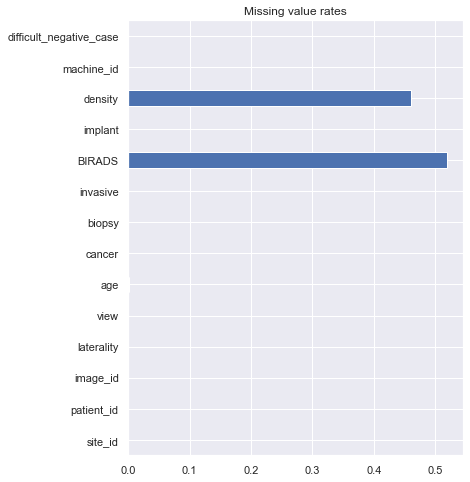

In [188]:
plt.figure(figsize=(6, 8))
train_df.isna().mean().plot(kind="barh")
plt.title("Missing value rates");

metadata

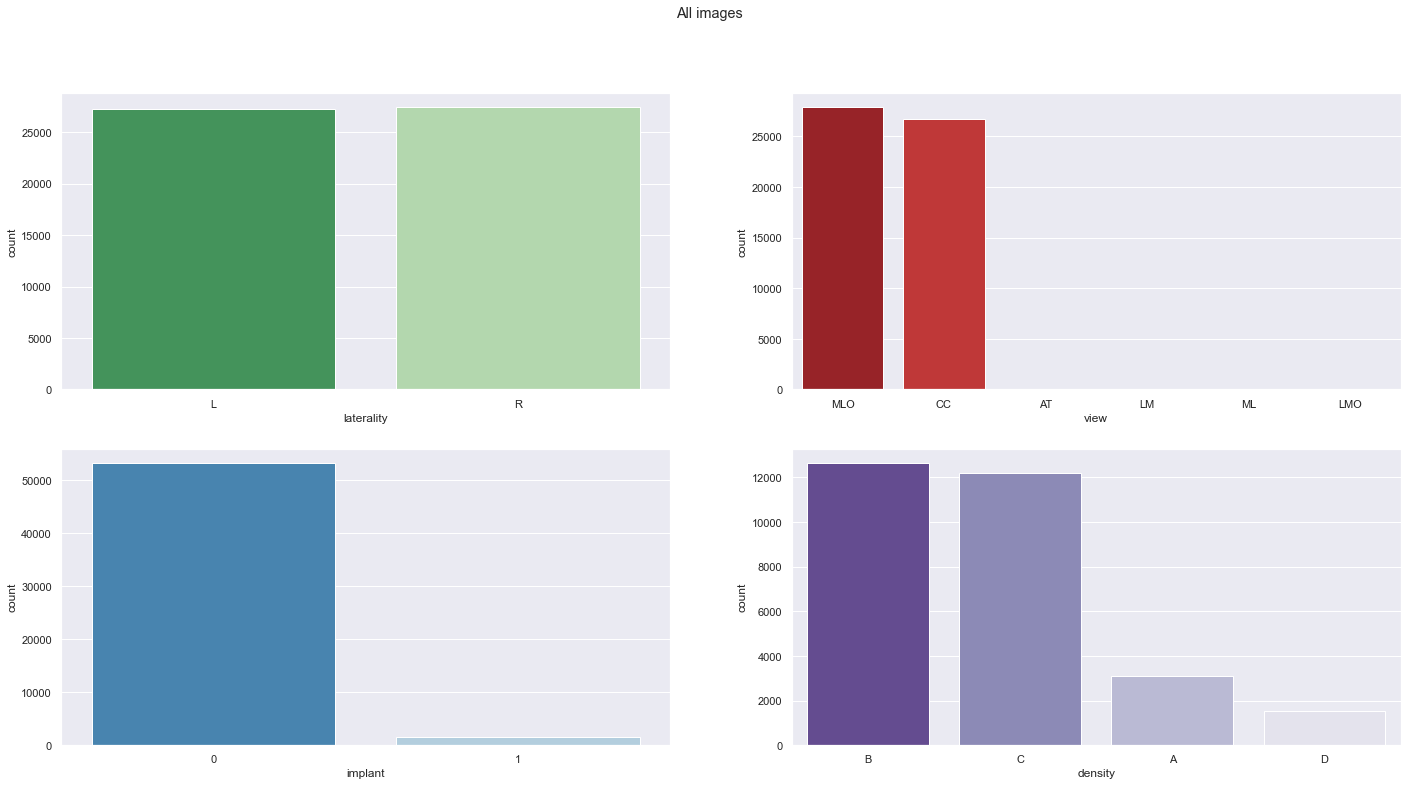

In [187]:
sns.set_theme()
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(24, 12))
axs = axs.flatten()
sns.countplot(x="laterality", data=train_df, ax=axs[0], palette="Greens_r")
sns.countplot(x="view", data=train_df, ax=axs[1], palette="Reds_r", order=train_df['view'].value_counts().index)
sns.countplot(x="implant", data=train_df, ax=axs[2], palette="Blues_r")
sns.countplot(x="density", data=train_df, ax=axs[3], palette="Purples_r", order=train_df['density'].value_counts().index)
plt.suptitle("All images");

how many patient?

In [134]:
print('The number of different patients is:', train_df.patient_id.nunique())

The number of different patients is: 11913


age distribution?

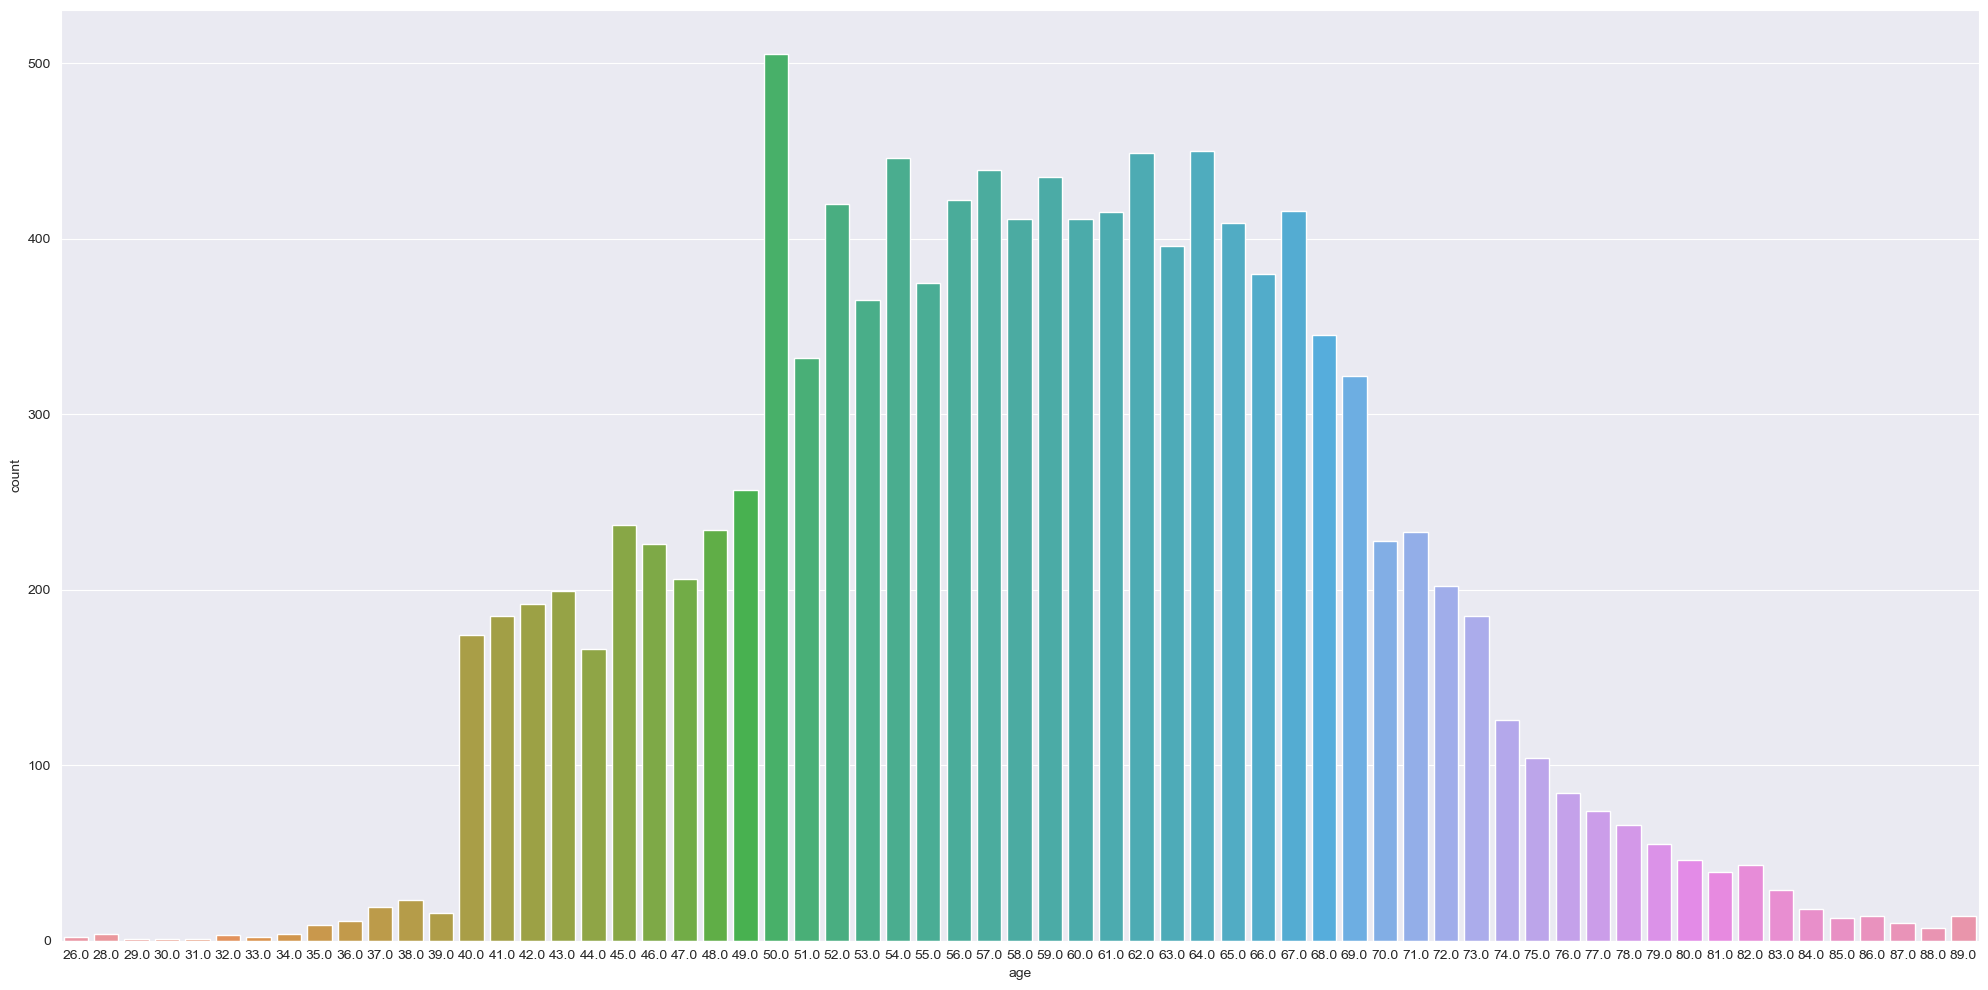

In [168]:
plt.figure(figsize = [20,10],dpi=100)
sns.countplot(x = train_df.groupby('patient_id').age.mean())
plt.tight_layout()


label distribution?

Text(0.5, 1.0, 'percentage of cancer and non-cancer')

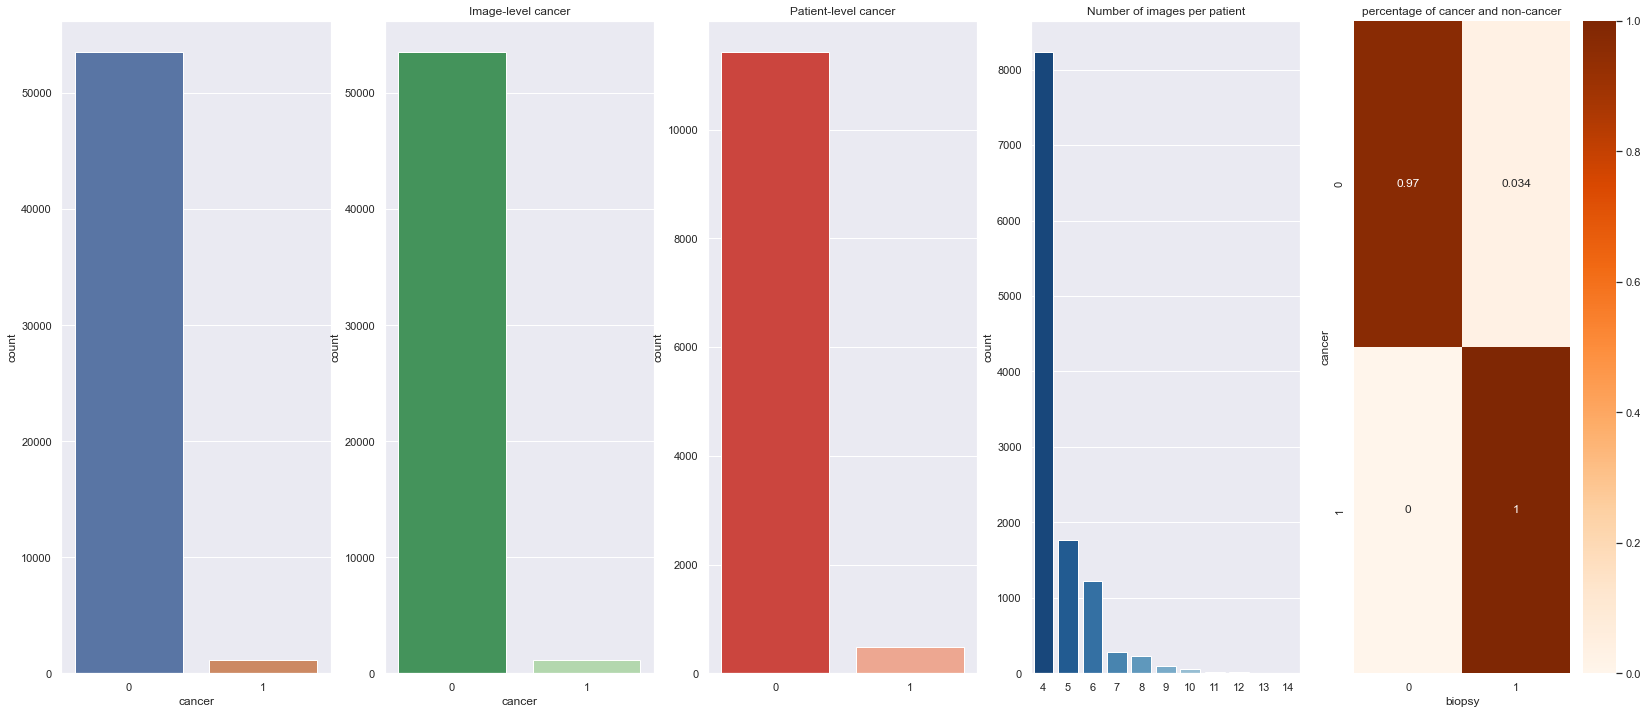

In [194]:
biopsy_counts = train_df.groupby('cancer').biopsy.value_counts().unstack().fillna(0) 
biopsy_perc = biopsy_counts.transpose() / biopsy_counts.sum(axis=1)
fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(1, 5, figsize=(28, 12))
sns.countplot(data=train_df, x = 'cancer', ax = ax0)
ax1.set_title("labels distribution")
sns.countplot(x="cancer", data=train_df, ax=ax1, palette="Greens_r")
ax1.set_title("Image-level cancer")
sns.countplot(x=train_df.groupby("patient_id")["cancer"].max().to_numpy(), ax=ax2, palette="Reds_r")
ax2.set_title("Patient-level cancer")
sns.countplot(x=train_df.groupby("patient_id")["image_id"].size().to_numpy(), ax=ax3, palette="Blues_r")
ax3.set_title("Number of images per patient");
sns.heatmap(biopsy_perc.transpose(), ax=ax4, annot=True, cmap='Oranges')
ax4.set_title("percentage of cancer and non-cancer")

machine id

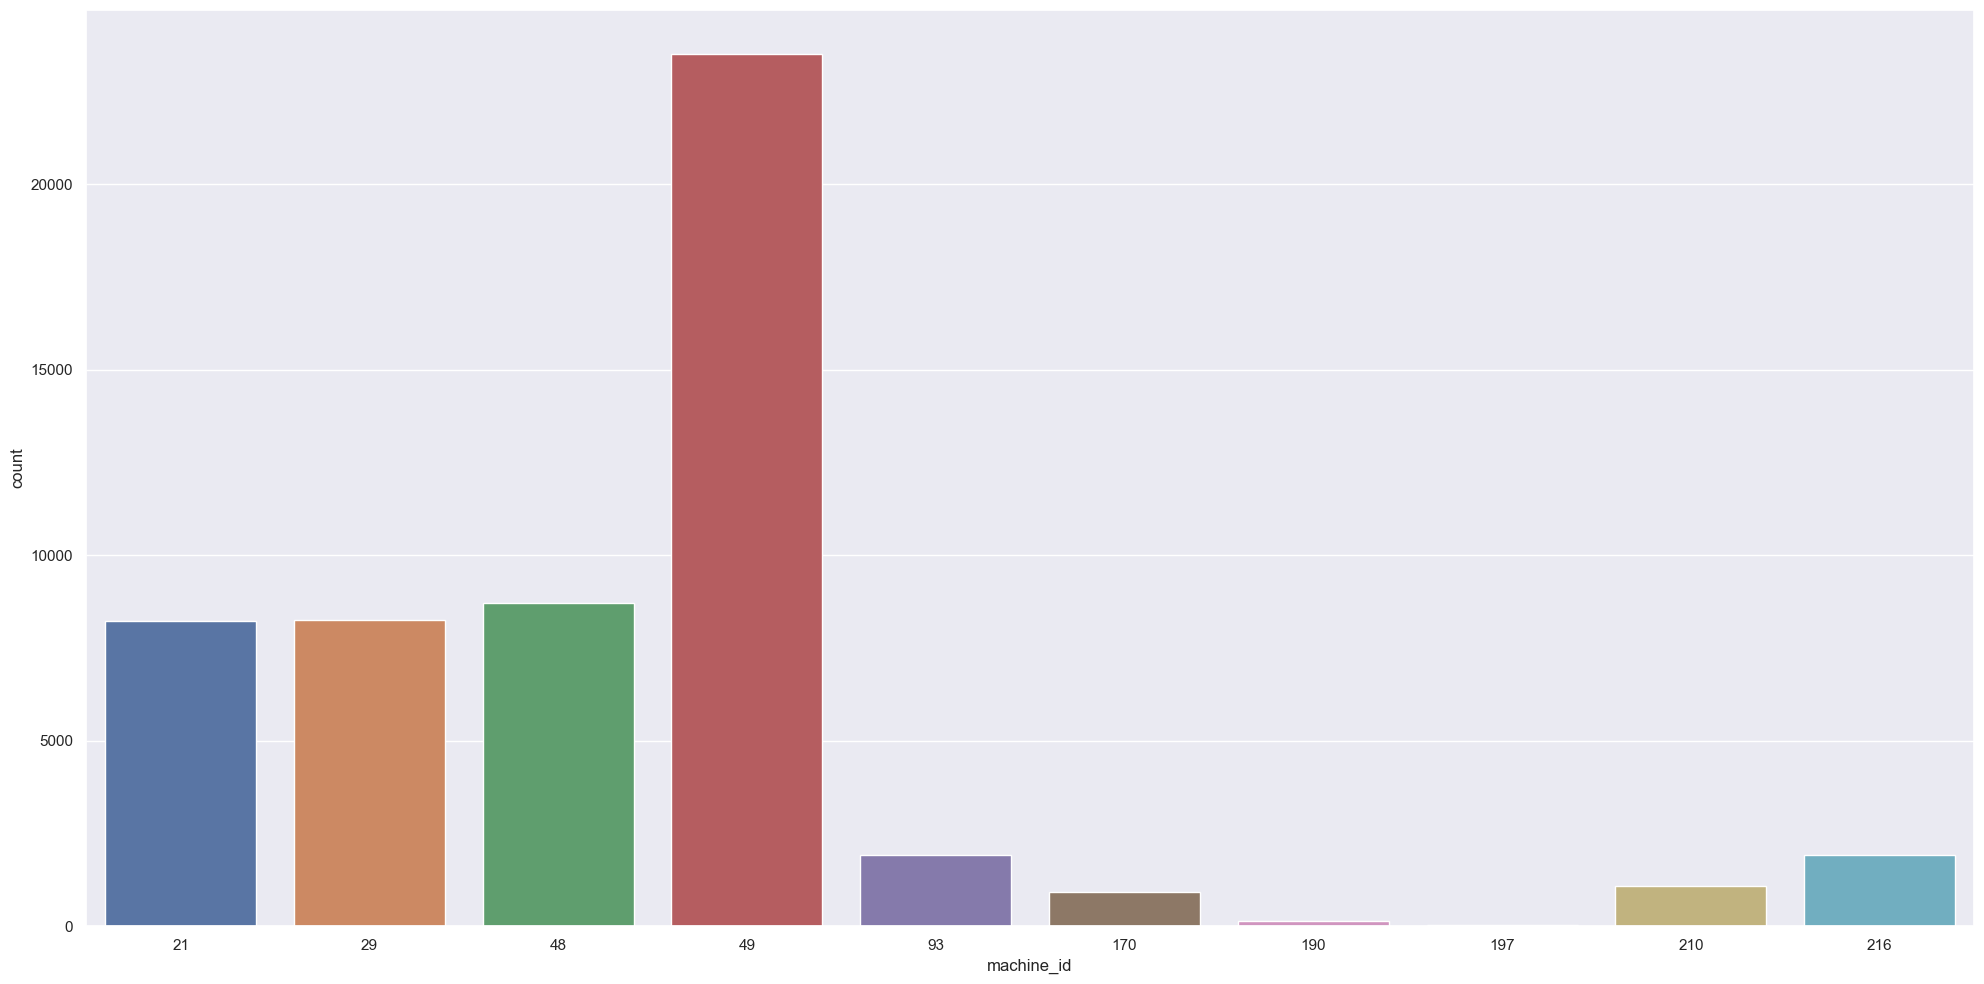

In [192]:
plt.figure(figsize = [20,10],dpi=100)
sns.countplot(data=train_df,x='machine_id')
plt.tight_layout()


```

for n in range(len(background_values)):
    print(machine_ids[n], np.median(background_values[n]), np.std(background_values[n]))

```


29 3524.0 215.81028705786943

21 0.0 0.0

216 0.0 146.7420539586386

93 0.0 289.45188477534566

49 0.0 0.0

48 0.0 0.0

170 0.0 0.0

210 1017.0 2.2293496809607953

190 0.0 67.79807427332629

197 83.5 219.29090268408308


# Conclusion
We need to be careful during preprocessing as background values were set differently depending on the machine id.